# Minkowski dot
> Does using Minkowski dot-products for classification do better?

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.hyperdt.toy_data import generate_gaussian_mixture_hyperboloid
from src.hyperdt.tree import HyperbolicDecisionTreeClassifier

from sklearn.model_selection import train_test_split


INFO: Using numpy backend


In [3]:
# Regular tree versus minkowski version

X, y = generate_gaussian_mixture_hyperboloid(
    num_points=1000, num_classes=2, n_dim=2
)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
tree1 = HyperbolicDecisionTreeClassifier(max_depth=2)
tree1.fit(X_train, y_train)
print(tree1.score(X_test, y_test))


class HDT_Minkowski(HyperbolicDecisionTreeClassifier):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.metric = "minkowski"

    def _dot(self, X, dim, theta):
        if self.sparse_dot_product and X.ndim == 1:
            return (
                -np.cos(theta) * X[self.timelike_dim] + np.sin(theta) * X[dim]
            )
        elif self.sparse_dot_product:
            return (
                -np.cos(theta) * X[:, self.timelike_dim]
                + np.sin(theta) * X[:, dim]
            )


tree2 = HDT_Minkowski(max_depth=2)
tree2.fit(X_train, y_train)
print(tree2.score(X_test, y_test))


0.74
0.82


In [17]:
# Wow, OK! That worked better... let's try many times

results = pd.DataFrame(columns=["dims", "trial", "minkowski", "dot"])

for dims in range(2, 16):
    for trial in range(100):
        try:
            X, y = generate_gaussian_mixture_hyperboloid(
                num_points=1000, num_classes=2, n_dim=dims
            )
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, random_state=42
            )
            tree1 = HyperbolicDecisionTreeClassifier(
                max_depth=2, timelike_dim=0
            )
            tree1.fit(X_train, y_train)
            tree2 = HDT_Minkowski(max_depth=20, timelike_dim=0)
            tree2.fit(X_train, y_train)
            results.loc[len(results)] = [
                dims,
                trial,
                tree1.score(X_test, y_test),
                tree2.score(X_test, y_test),
            ]
        except Exception as e:
            print(str(e))
            continue

results


Points must lie on a hyperboloid
Points must lie on a hyperboloid
Points must lie on a hyperboloid
Points must lie on a hyperboloid
Points must lie on a hyperboloid
Points must lie on a hyperboloid
Points must lie on a hyperboloid
Points must lie on a hyperboloid
Points must lie on a hyperboloid
Points must lie on a hyperboloid
Points must lie on a hyperboloid
Points must lie on a hyperboloid
Points must lie on a hyperboloid
Points must lie on a hyperboloid
Points must lie on a hyperboloid
Points must lie on a hyperboloid
Points must lie on a hyperboloid
Points must lie on a hyperboloid
Points must lie on a hyperboloid
Points must lie on a hyperboloid
Points must lie on a hyperboloid
Points must lie on a hyperboloid
Points must lie on a hyperboloid
Points must lie on a hyperboloid
Points must lie on a hyperboloid
Points must lie on a hyperboloid
Points must lie on a hyperboloid
Points must lie on a hyperboloid
Points must lie on a hyperboloid
Points must lie on a hyperboloid
Points mus

,dims,trial,minkowski,dot
0,2.0,0.0,0.860000,0.865000
1,2.0,1.0,0.870000,0.815000
2,2.0,2.0,0.850000,0.825000
3,2.0,3.0,0.840000,0.845000
4,2.0,4.0,0.950000,0.930000
...,...,...,...,...
388,7.0,41.0,0.785000,0.825000
389,7.0,65.0,0.718593,0.874372
390,7.0,75.0,0.757576,0.803030
391,7.0,80.0,0.824121,0.894472


array([<Axes: title={'center': 'minkowski'}, xlabel='dims'>,
       <Axes: title={'center': 'dot'}, xlabel='dims'>], dtype=object)

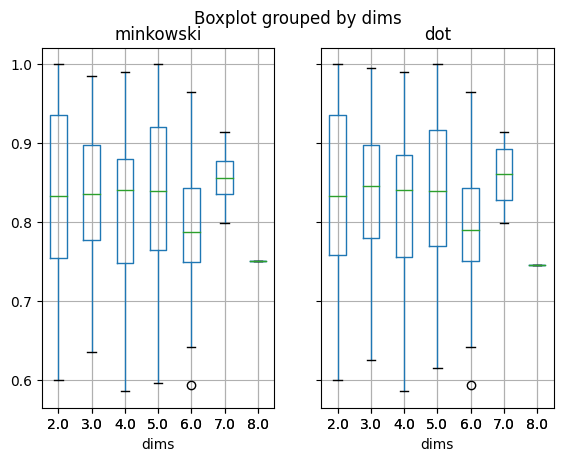

In [9]:
# So here we can see that we always do better with regular dot product. This
# makes sense since the regular Euclidean dot product has the interpretation of
# "to one side of the hyperplane" and "to the other side of the hyperplane",
# and the Minkowski dot product does not have this interpretation.

results.boxplot(column=["minkowski", "dot"], by="dims")


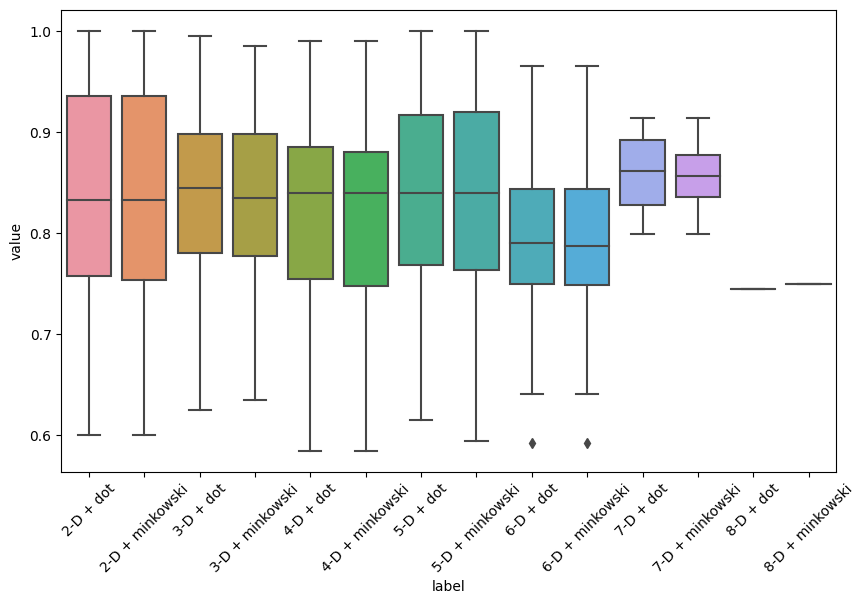

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Melt the dataframe
df_melted = results.melt(
    id_vars=["dims"],
    value_vars=["minkowski", "dot"],
    var_name="metric",
    value_name="value",
).sort_values(by=["dims", "metric"])

# Create custom labels
df_melted["label"] = (
    df_melted["dims"].astype(int).astype(str) + "-D + " + df_melted["metric"]
)

# Plot
plt.figure(figsize=[10, 6])
sns.boxplot(x="label", y="value", data=df_melted)
plt.xticks(rotation=45)
plt.show()


In [15]:
df_melted.sort_values("dims")


,dims,metric,value,label
0,2.0,minkowski,0.740000,2-D + minkowski
465,2.0,dot,0.710000,2-D + dot
464,2.0,dot,0.735000,2-D + dot
463,2.0,dot,0.840000,2-D + dot
462,2.0,dot,0.835000,2-D + dot
...,...,...,...,...
387,7.0,minkowski,0.913706,7-D + minkowski
782,7.0,dot,0.837563,7-D + dot
781,7.0,dot,0.884422,7-D + dot
391,8.0,minkowski,0.750000,8-D + minkowski
